# Binary Classification

## Import relevant modules

In [2]:
# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

## Load the datasets from the internet

In [3]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

## Normalize values

In [4]:
# Calculate the Z-scores of each column in the "test set"
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

# Calculate the Z-scores of each column in the "training set"
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13697,-1.2,0.6,-1.1,0.2,0.6,-0.1,0.5,-0.9,0.1
10396,-0.3,0.6,-0.6,-0.4,-0.6,-0.5,-0.6,-0.7,-1.0
11235,-0.8,1.6,-1.6,-0.1,-0.4,-0.5,-0.4,0.3,-0.0
13397,-1.2,1.0,-0.5,-0.3,-0.6,-0.5,-0.5,1.3,0.4
15503,-1.4,1.1,0.4,0.0,0.3,-0.1,0.1,-0.7,-0.8


## Create a binary label

In [11]:
# We arbitrarily set the threshold to 265,000, which is the 75th percentile for median house values. 
# Every neighborhood with a median house price above 265000 will be labeled 1, and all other will be labeled 0.
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)

13697   0.0
10396   0.0
11235   0.0
13397   0.0
15503   0.0
         ..
1434    0.0
12463   1.0
6102    0.0
7955    1.0
1419    0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

## Represent features in feature columns

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 

In [6]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied to train_df_norm:
feature_layer(dict(train_df_norm))

2022-08-16 18:01:37.783228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-0.8943072 ,  0.18364464],
       [-0.6720508 , -0.44802207],
       [ 0.32524684, -0.12370227],
       ...,
       [-1.5002848 , -1.1292313 ],
       [-1.0898887 , -0.78518623],
       [-0.48616457, -0.33976257]], dtype=float32)>

## Define build and train model function

In [15]:
def create_model(my_learning_rate, feature_layer, my_metrics):
    """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented) to the model.
    model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that TensorFlow can execute. 
  # Notice that we're using a different loss function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=my_metrics)

    return model        


def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, 
                        y=label, 
                        batch_size=batch_size,
                        epochs=epochs, 
                        shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

  # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

## Define a plotting function

In [16]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""   

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

## Call the model functions

/Users/nguyenhien/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
170/170 [==============================] - 2s 2ms/step - loss: 0.7828 - accuracy: 0.3835 - precision: 0.2369 - recall: 0.6607
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6968 - accuracy: 0.4854 - precision: 0.2786 - recall: 0.6671
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6236 - accuracy: 0.5969 - precision: 0.3464 - recall: 0.6920
Epoch 4/20
170/170 [==============================] - 0s 3ms/step - loss: 0.5623 - accuracy: 0.6790 - precision: 0.4135 - recall: 0.6812
Epoch 5/20
170/170 [==============================] - 1s 3ms/step - loss: 0.5128 - accuracy: 0.7361 - precision: 0.4793 - recall: 0.6546
Epoch 6/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4745 - accuracy: 0.7701 - precision: 0.5341 - recall: 0.6228
Epoch 7/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4473 - accuracy: 0.7924 - precision: 0.5807 - recall: 0.6077
Epoch 8/20
170/170 [=====================

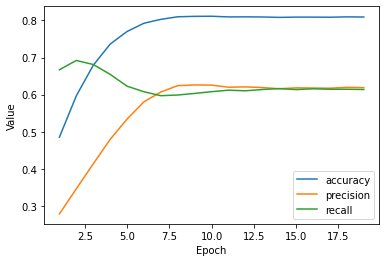

In [17]:
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
    # Calculates how often predictions match binary labels.
      tf.keras.metrics.BinaryAccuracy(threshold=classification_threshold, name='accuracy'), 
    # Computes the precision of the predictions with respect to the labels.
      tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision' ),
    # Computes the recall of the predictions with respect to the labels.
      tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

## Experiment with the classification threshold (if time permits)

Epoch 1/20


/Users/nguyenhien/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 1s 2ms/step - loss: 0.6296 - accuracy: 0.6876 - precision: 0.4242 - recall: 0.7014
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5656 - accuracy: 0.7332 - precision: 0.4758 - recall: 0.6692
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5163 - accuracy: 0.7632 - precision: 0.5213 - recall: 0.6386
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4776 - accuracy: 0.7869 - precision: 0.5680 - recall: 0.6146
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4481 - accuracy: 0.8035 - precision: 0.6104 - recall: 0.5896
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.8138 - precision: 0.6471 - recall: 0.5604
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4120 - accuracy: 0.8240 - precision: 0.6904 - recall: 0.5357
Epoch 8/20
170/170 [==============================] 

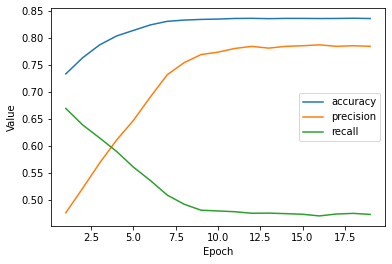

In [18]:
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
    # Calculates how often predictions match binary labels.
      tf.keras.metrics.BinaryAccuracy(threshold=classification_threshold, name='accuracy'), 
    # Computes the precision of the predictions with respect to the labels.
      tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision' ),
    # Computes the recall of the predictions with respect to the labels.
      tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

## Summarize model performance (if time permits)

/Users/nguyenhien/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
170/170 [==============================] - 1s 3ms/step - loss: 0.6280 - auc: 0.7977
Epoch 2/20
170/170 [==============================] - 0s 3ms/step - loss: 0.5773 - auc: 0.8043
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5338 - auc: 0.8099
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4955 - auc: 0.8152
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4631 - auc: 0.8205
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4385 - auc: 0.8248
Epoch 7/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4202 - auc: 0.8292
Epoch 8/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4086 - auc: 0.8323
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4019 - auc: 0.8347
Epoch 10/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3989 - auc: 0.8360
Epoch 11/20
170/170 [============================

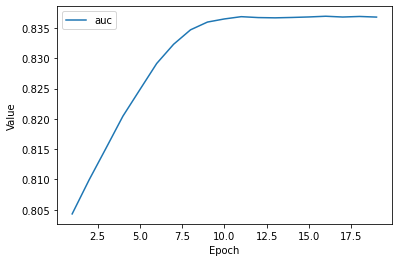

In [23]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)